## Preprocesamiento

El dataset contiene 5000 posts de los cuales se obtendrán las características para el análisis. 

In [1]:
from bs4 import BeautifulSoup
import pandas as pd

df=pd.read_csv("stackoverflow_data.csv", quotechar='"',
               usecols=['post_id','accepted_ans','post_title','post_body','post_creation_date',
                            'post_answer_count','post_comment_count',
                            'post_favorite_count', 'post_score','post_tags',
                            'post_view_count','users_creation_date',
                            'users_reputation','users_up_votes','users_down_votes',
                            'score_prev_acceptans' ,'score_prev_ans',
                            'score_prev_comment','score_prev_question',
                            'score_prev_favquestion'])
#Archivo con los tags mas populares
df_tags=pd.read_csv("top_tags.csv", quotechar='"')
#Se elimina registros con valores nulos
df.dropna() 
df['post_creation_date']=pd.to_datetime(df['post_creation_date'])
df['users_creation_date']=pd.to_datetime(df['users_creation_date'])
df['class']=df['post_answer_count'].apply(lambda x: 1 if x>0 else 0)

In [2]:
df.head()

,post_id,accepted_ans,post_title,post_body,post_creation_date,post_answer_count,post_comment_count,post_favorite_count,post_score,post_tags,...,users_creation_date,users_reputation,users_up_votes,users_down_votes,score_prev_acceptans,score_prev_ans,score_prev_comment,score_prev_question,score_prev_favquestion,class
0,40287199,0,Define the correct NSTableView behavior with d...,<p>I have a view based NSTableView in my appli...,2016-10-27 14:24:53.537,0,1,0,0,osx|cocoa|tableview|nstableview|nswindow,...,2011-08-08 21:57:35.103,1848,142,30,40,64,28,4,0,0
1,43396867,0,Undefined variable but already declared,<p>I'm trying to make a simple form that can c...,2017-04-13 15:59:39.453,0,6,0,0,php|mysql,...,2017-04-13 15:43:24.877,1,0,0,0,0,0,0,0,0
2,39747783,0,How to ignore folder in just post_process whil...,<p>Is there any way to ignore a folder only fo...,2016-09-28 12:38:00.257,0,2,0,0,django|deployment,...,2014-03-31 16:03:04.167,62,2,0,0,3,0,5,0,0
3,44417709,0,Java wildfly java.lang.NoClassDefFoundError,<p>I am developing javaee maven web project us...,2017-06-07 16:03:59.080,0,5,0,0,java|java-ee|wildfly,...,2013-01-31 19:55:55.543,66,9,0,0,0,1,4,0,0
4,41607780,0,Execution failed for task :app:transformClasse...,<p>I am trying to release my Android applicati...,2017-01-12 07:54:29.743,0,5,0,0,android|android-studio|gradle,...,2017-01-12 07:42:58.243,3,0,0,0,0,0,0,0,0


In [3]:
#Se considera las features que se utilizarán en el clasificador. 

df2 = pd.DataFrame(data=df, index=df.index, columns=['class',
                            'post_comment_count',
                            'post_favorite_count', 'post_score',
                            'post_view_count',
                            'users_reputation',	'users_up_votes','users_down_votes',
                            'score_prev_acceptans' ,'score_prev_ans',
                            'score_prev_comment','score_prev_question',
                            'score_prev_favquestion']
                   )
#Edad de creacion de la cuenta en relacion al post en dias.
df2['age_user'] = (df['post_creation_date'] - df['users_creation_date']).fillna(0).astype('timedelta64[D]')
df2['title_length'] = df['post_title'].apply(lambda x: len(x))
df2['num_block_code'] = 0
df2["num_i_sentences"]=0
df2["num_wh_words"]=0
df2["num_y_sentences"]=0
df2["tags_popularity"]=0
df2["num_tags"]=0

whwords=['what','how', 'which', 'when', 'why', 'where']
for index, row in df.iterrows():
    sbody=row["post_body"]
    soup = BeautifulSoup(sbody, "html5lib")
    sentences =  soup.find_all(name="p")
    #Questions words
    count_wh=0
    #Oraciones que tienen el pronombre I
    count_is=0
    #Oraciones que tienen el pronombre You
    count_ys = 0
    for sentence in sentences:
        try:
            count_is = count_is + len([x for x in sentence.contents[0].split() if (x == "I")])
            count_is = count_is + (len(sentence.contents[0].split("I'")) - 1)
        except:
            count_is = count_is + len([x for x in str(sentence.contents).split() if (x == "I")])
            count_is = count_is + (len(str(sentence.contents).split("I'")) - 1)

        try:
            count_ys = count_ys + len([x for x in sentence.contents[0].split() if (x == "you")])
            count_ys = count_ys + (len(sentence.contents[0].split("you'")) - 1)
        except:
            count_ys = count_ys + len([x for x in str(sentence.contents).split() if (x == "you")])
            count_ys = count_ys + (len(str(sentence.contents).split("you'")) - 1)

        for word in whwords:
            try:
                count_wh=count_wh+len([x for x in sentence.contents[0].split() if x == word])
            except:
                count_wh = count_wh + len([x for x in str(sentence.contents).split() if x == word])
    df2.loc[index, "num_i_sentences"] = count_is
    df2.loc[index, "num_wh_words"] = count_wh
    df2.loc[index, "num_y_sentences"] = count_ys
    
#Caracteristicas del texto del post
for index, row in df.iterrows():
    body=row["post_body"]
    tags=row["post_tags"]
    counttag=len(tags.split("|"))
    soup = BeautifulSoup(body, "html5lib")
    precode = soup.find_all("pre")
    df2.loc[index, "num_block_code"]=len(precode)
    content=""
    countError = 0
    for codeline in precode:
        contentPre = codeline.contents
        for contentCode in contentPre:
            try:
                content=content+contentCode.contents[0]
            except :
                try:
                    content = content + str(contentCode)
                except:
                    print(contentCode)
    wordCodeCount =len(content)
    df2.loc[index,"code_length"]=wordCodeCount
#numero de tags y popularidad del tag
for index, row in df.iterrows():
    tags_column=row["post_tags"]
    tags=tags_column.split("|")
    counttag=len(tags)
    pop_tag=0
    for tag in tags:
        if tag in df_tags['tag_name'].values:
            pop_tag+=1;
    df2.loc[index, "num_tags"] = counttag
    df2.loc[index, "tags_popularity"] = pop_tag
df2.head()

,class,post_comment_count,post_favorite_count,post_score,post_view_count,users_reputation,users_up_votes,users_down_votes,score_prev_acceptans,score_prev_ans,...,score_prev_favquestion,age_user,title_length,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,tags_popularity,num_tags,code_length
0,0,1,0,0,55,1848,142,30,40,64,...,0,1906.0,60,0,4,1,0,1,5,0.0
1,0,6,0,0,19,1,0,0,0,0,...,0,0.0,39,1,3,1,0,2,2,2262.0
2,0,2,0,0,27,62,2,0,0,3,...,0,911.0,69,1,1,1,0,1,2,49.0
3,0,5,0,0,76,66,9,0,0,0,...,0,1587.0,43,2,5,2,0,1,3,20340.0
4,0,5,0,0,287,3,0,0,0,0,...,0,0.0,81,1,1,0,0,1,3,869.0


Se obtuvieron 21 características para el primer análisis. 

# Limpieza y Estadísticas

In [4]:
import pandas as pd
import numpy as np

Se obtiene el dataset de las features generadas

In [12]:
num_features = ['post_comment_count',
                'post_favorite_count','post_score',
                'post_view_count','users_reputation','users_up_votes',
                'users_down_votes','score_prev_acceptans',
                'score_prev_ans','score_prev_comment',
                'score_prev_question','score_prev_favquestion',
                'age_user','title_length','num_block_code','num_i_sentences',
                'num_wh_words','num_y_sentences','tags_popularity','num_tags','code_length']


In [6]:
df_statistics=pd.DataFrame(index=num_features)
for index, row in df_statistics.iterrows():
    df_statistics.loc[index,"min"]=df2[index].min()
    df_statistics.loc[index,"max"] = df2[index].max()
    df_statistics.loc[index,"mean"] = df2[index].mean()
    df_statistics.loc[index,"std"] = df2[index].std()
    df_statistics.loc[index,"var"] = df2[index].var()
df_statistics

,min,max,mean,std,var
post_comment_count,0.0,39.0,2.1324,2.839733,8.064083e+00
post_favorite_count,0.0,19.0,0.1400,0.558267,3.116623e-01
post_score,-8.0,59.0,0.5542,2.016302,4.065475e+00
post_view_count,5.0,38320.0,241.6304,930.855619,8.664922e+05
users_reputation,0.0,229974.0,969.8716,5746.156694,3.301832e+07
users_up_votes,0.0,24787.0,159.6094,672.061197,4.516663e+05
users_down_votes,0.0,3665.0,14.7166,109.408935,1.197032e+04
score_prev_acceptans,-7.0,11804.0,27.0564,280.743409,7.881686e+04
score_prev_ans,-7.0,19751.0,49.0104,456.015890,2.079505e+05
score_prev_comment,0.0,7017.0,22.9510,169.400217,2.869643e+04


Todos los atributos tienen una varianza significativa para considerarlos en el análisis. El atributo age_user tiene un valor negativo, que se elimina del dataset este registro y se analiza las características que tienen valores maximos demasiado elevados.

In [7]:
df2= df2.loc[df2['age_user'] >=0, :]

In [8]:
df2.describe()

,class,post_comment_count,post_favorite_count,post_score,post_view_count,users_reputation,users_up_votes,users_down_votes,score_prev_acceptans,score_prev_ans,...,score_prev_favquestion,age_user,title_length,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,tags_popularity,num_tags,code_length
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,...,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,0.772755,2.132827,0.140028,0.554311,241.676535,970.065413,159.641328,14.719544,27.061812,49.020204,...,2.564113,740.079016,53.926185,1.470894,3.507301,1.042408,0.147830,1.397079,3.021804,959.554911
std,0.419094,2.839857,0.558320,2.016489,930.943020,5746.715166,672.124634,109.419682,280.771232,456.060981,...,6.449595,725.843191,20.386255,1.404098,2.896075,1.270294,0.464367,0.979052,1.218654,1972.265429
min,0.000000,0.000000,0.000000,-8.000000,5.000000,0.000000,0.000000,0.000000,-7.000000,-7.000000,...,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,39.000000,13.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,77.000000,39.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,69.000000,73.000000,10.000000,0.000000,0.000000,0.000000,...,0.000000,528.000000,51.000000,1.000000,3.000000,1.000000,0.000000,1.000000,3.000000,353.000000
75%,1.000000,3.000000,0.000000,1.000000,173.000000,476.000000,75.000000,2.000000,3.000000,8.500000,...,2.000000,1239.500000,65.000000,2.000000,5.000000,2.000000,0.000000,2.000000,4.000000,997.500000
max,1.000000,39.000000,19.000000,59.000000,38320.000000,229974.000000,24787.000000,3665.000000,11804.000000,19751.000000,...,150.000000,3203.000000,149.000000,17.000000,25.000000,10.000000,7.000000,5.000000,5.000000,25051.000000


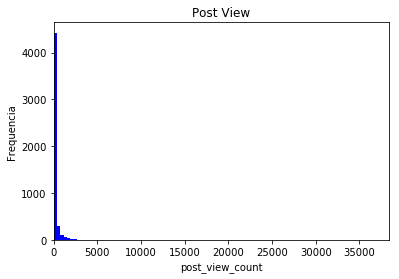

In [6]:
import matplotlib.pyplot as plt
plt.hist(df2['post_view_count'], bins=100, color="blue")
plt.xlim(xmin=0, xmax=df2['post_view_count'].max())
plt.title("Post View")
plt.ylabel("Frequencia")
plt.xlabel("post_view_count")
plt.show()

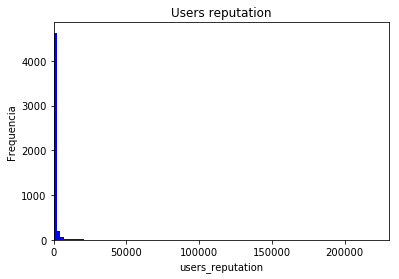

In [7]:
plt.hist(df2['users_reputation'], bins=100, color="blue")
plt.xlim(xmin=0, xmax=df2['users_reputation'].max())
plt.title("Users reputation")
plt.ylabel("Frequencia")
plt.xlabel("users_reputation")
plt.show()

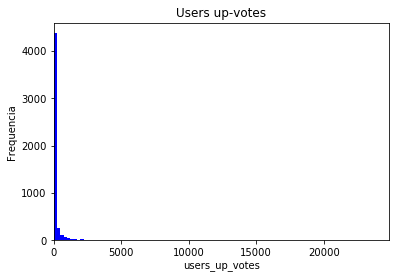

In [11]:
plt.hist(df2['users_up_votes'], bins=100, color="blue")
plt.xlim(xmin=0, xmax=df2['users_up_votes'].max())
plt.title("Users up-votes")
plt.ylabel("Frequencia")
plt.xlabel("users_up_votes")
plt.show()

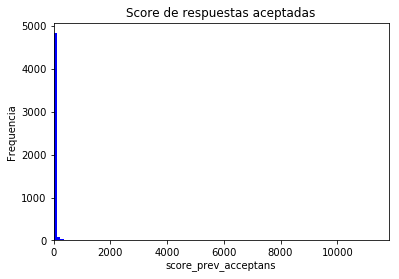

In [12]:
plt.hist(df2['score_prev_acceptans'], bins=100, color="blue")
plt.xlim(xmin=0, xmax=df2['score_prev_acceptans'].max())
plt.title("Score de respuestas aceptadas")
plt.ylabel("Frequencia")
plt.xlabel("score_prev_acceptans")
plt.show()

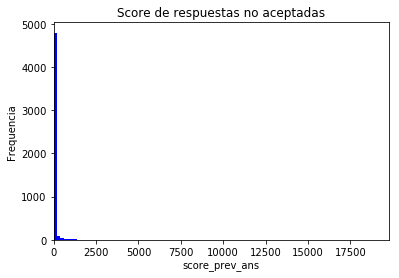

In [13]:
plt.hist(df2['score_prev_ans'], bins=100, color="blue")
plt.xlim(xmin=0, xmax=df2['score_prev_ans'].max())
plt.title("Score de respuestas no aceptadas")
plt.ylabel("Frequencia")
plt.xlabel("score_prev_ans")
plt.show()

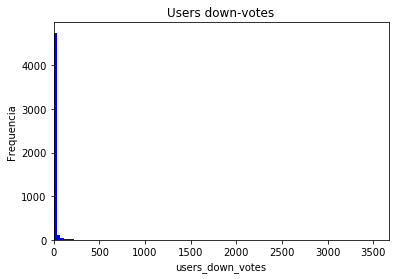

In [14]:
plt.hist(df2['users_down_votes'], bins=100, color="blue")
plt.xlim(xmin=0, xmax=df2['users_down_votes'].max())
plt.title("Users down-votes")
plt.ylabel("Frequencia")
plt.xlabel("users_down_votes")
plt.show()

Los valores altos de las características analizadas son de un valor reducido de datos. Creamos una matriz de correlación para identificar atributos que se puedan eliminar por que tienen una alta correlación. 

In [8]:
import seaborn as sns
df_rel=pd.DataFrame(data=df2, columns=['users_reputation', 'users_up_votes',
                'users_down_votes', 'score_prev_acceptans',
                'score_prev_ans', 'score_prev_comment',
                'score_prev_question', 'score_prev_favquestion',
                'age_user'], index=df2.index)

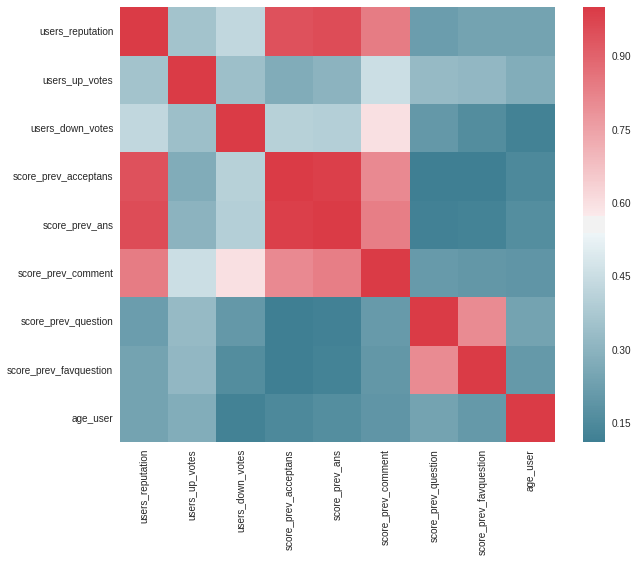

In [16]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_rel.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

Se puede ver que las características que corresponden al score de las respuestas dadas por el usuarios (score_prev_acceptans, score_prev_ans) tienen alta correlación con su reputación; sin embargo creemos por el momento considerar estos atributos y posteriormente analizar grupos que tengan valores similares en estas características.

Filtramos los datos para eliminar los registros que tengan el atibuto users_reputation demasiado alto. 

In [9]:
df2= df2.loc[df2['users_reputation'] <10000, :]

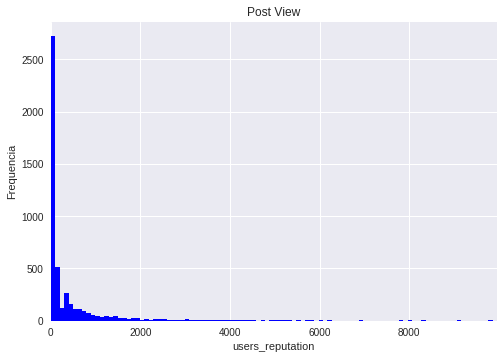

In [10]:
plt.hist(df2['users_reputation'], bins=100, color="blue")
plt.xlim(xmin=0, xmax=df2['users_reputation'].max())
plt.title("Post View")
plt.ylabel("Frequencia")
plt.xlabel("users_reputation")
plt.show()

In [19]:
df2.describe()

,class,post_comment_count,post_favorite_count,post_score,post_view_count,users_reputation,users_up_votes,users_down_votes,score_prev_acceptans,score_prev_ans,...,score_prev_favquestion,age_user,title_length,num_block_code,num_i_sentences,num_wh_words,num_y_sentences,tags_popularity,num_tags,code_length
count,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,...,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000,4917.000000
mean,0.772829,2.128940,0.130567,0.522676,239.886923,516.306894,127.189140,9.419361,9.393736,19.443156,...,2.327435,717.208257,53.872687,1.469595,3.498271,1.041285,0.147041,1.399837,3.021151,965.821843
std,0.419047,2.833394,0.448797,1.756119,932.852061,1172.148939,503.945676,68.835956,43.342707,69.637214,...,5.771426,706.070565,20.386682,1.402275,2.896058,1.265957,0.464065,0.980062,1.215392,1983.593206
min,0.000000,0.000000,0.000000,-8.000000,5.000000,0.000000,0.000000,0.000000,-7.000000,-7.000000,...,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,39.000000,13.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,73.000000,39.000000,0.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000
50%,1.000000,1.000000,0.000000,0.000000,69.000000,69.000000,9.000000,0.000000,0.000000,0.000000,...,0.000000,509.000000,51.000000,1.000000,3.000000,1.000000,0.000000,1.000000,3.000000,355.000000
75%,1.000000,3.000000,0.000000,1.000000,172.000000,439.000000,66.000000,1.000000,3.000000,7.000000,...,2.000000,1204.000000,65.000000,2.000000,5.000000,2.000000,0.000000,2.000000,4.000000,1007.000000
max,1.000000,39.000000,8.000000,36.000000,38320.000000,9961.000000,17298.000000,2527.000000,1993.000000,2028.000000,...,150.000000,3203.000000,149.000000,17.000000,25.000000,10.000000,7.000000,5.000000,5.000000,25051.000000


Con el filtro aplicado se tiene 4918 registros, es decir menos del 10% tenían valores altos en el atributo users_reputation y en los atributos de score relacionados. 

## Normalización

Debido a la heterogeneidad del dataset es necesario normalizar los datos, para ello usamos la función z-score que sirve para normalizar los datos cuando la diferencia entre el valor mínimo y máximo es demasiado grande. 

In [13]:
for each in num_features:
    mean, std = df2[each].mean(), df2[each].std()
    df2.loc[:, each] = (df2[each] - mean)/std

## Clasificación

Se usa el clasificador Super Vector Machine lineal, considerando que existen dos clases, además se realiza la clasificación con grupos de entrenamiento para finalmente realizar la predicción. Debido a que el dataset contiene el 22% de la clase 0, esperamos que el valor Recall sea alto.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_predict

X = df2.iloc[:,1:]
y = df2.iloc[:,0]

clf=svm.SVC(kernel="linear",random_state=10)


In [15]:
print("Clasificador SVM")
print()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50,random_state=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("precision", np.mean(metrics.precision_score(y_test, y_pred)))
print("recall", np.mean(metrics.recall_score(y_test, y_pred)))
print("f1", np.mean(metrics.f1_score(y_test, y_pred)))
print("accuracy", np.mean(metrics.accuracy_score(y_test, y_pred)))
print()

Clasificador SVM

precision 0.8
recall 1.0
f1 0.888888888889
accuracy 0.8



Con el clasificador SVM obtuvimos el máximo Recall esperado de 1 y accuracy de 0.68. 

Para evitar un sobreajuste de los datos, cambiamos los grupos de entrenamiento por el método cross-validation, que permite considerar la clase de menor proporción en los conjuntos de ejemplo con mayor probabilidad. Usamos la raíz de N como k-fold.  


In [16]:
clf.fit(X,y)
y_pred=cross_val_predict(clf, X, y, cv=70)
print("SVM - Cross-validation")
print()
print("precision", np.mean(metrics.precision_score(y, y_pred)))
print("recall", np.mean(metrics.recall_score(y, y_pred)))
print("f1", np.mean(metrics.f1_score(y, y_pred)))
print("accuracy", np.mean(metrics.accuracy_score(y, y_pred)))
print()

SVM - Cross-validation

precision 0.772875152501
recall 1.0
f1 0.871888978094
accuracy 0.772875152501



Se obtuvo un mayor valor de accuracy usando cross-validation. 

Para evaluar el clasificador usamos DummyClassifier además de otros clasificadores como  Decision Tree, Naive Bayes y KNeighbors, para comparar los resultados. 

Para el DummyClassifier se aplica la estrategia "stratify", para que la muestra sea equitativa para las 2 clases. 

In [32]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

c1 = ("Decision Tree", DecisionTreeClassifier())
c2 = ("Gaussian NB", GaussianNB())
# Para definir el numero de vecinos para KNN se aplica la raiz cuadrada de n 
c3 = ("KNeighbors", KNeighborsClassifier(n_neighbors=70))
c4 =  ("SVC",svm.SVC(kernel="linear",random_state=10))
c5 = ("Dummy: stratified", DummyClassifier(strategy="stratified", random_state=10))

clasificadores=[c1, c2, c3, c4, c5]

summary=pd.DataFrame(index=['precision','recall', 'f1', 'accuracy'], columns=['Decision Tree','Gaussian NB','KNeighbors','SVC',
                                                                              'Dummy: stratified'])
    

In [34]:
for name, clf in clasificadores:
    print(name)
    clf.fit(X,y)
    y_pred=cross_val_predict(clf, X, y, cv=70)
    summary.loc['precision',name]=np.mean(metrics.precision_score(y, y_pred))
    summary.loc['recall', name] = np.mean(metrics.recall_score(y, y_pred))
    summary.loc['f1', name] = np.mean(metrics.f1_score(y, y_pred))
    summary.loc['accuracy', name]=np.mean(metrics.accuracy_score(y, y_pred))

Decision Tree
Gaussian NB
KNeighbors
SVC
Dummy: stratified


In [35]:
summary

,Decision Tree,Gaussian NB,KNeighbors,SVC,Dummy: stratified
precision,0.808998,0.892971,0.772875,0.772875,0.763885
recall,0.790055,0.294133,1,1,0.777953
f1,0.799414,0.442509,0.871889,0.871889,0.770855
accuracy,0.693575,0.427206,0.772875,0.772875,0.642538


In [36]:
from sklearn.ensemble import ExtraTreesClassifier

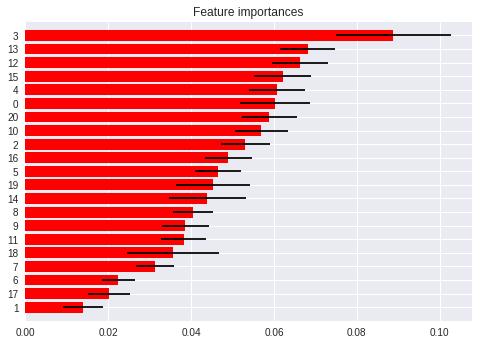

In [39]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)

plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", xerr=std[indices], align="center")

plt.yticks(range(X.shape[1]), indices)
plt.ylim([-1, X.shape[1]])
plt.show()

In [40]:
num_features

['post_comment_count',
 'post_favorite_count',
 'post_score',
 'post_view_count',
 'users_reputation',
 'users_up_votes',
 'users_down_votes',
 'score_prev_acceptans',
 'score_prev_ans',
 'score_prev_comment',
 'score_prev_question',
 'score_prev_favquestion',
 'age_user',
 'title_length',
 'num_block_code',
 'num_i_sentences',
 'num_wh_words',
 'num_y_sentences',
 'tags_popularity',
 'num_tags',
 'code_length']

La primera característica que destaca es la de el número de vistas del post, seguido del tamaño del título, las oraciones que inician con el pronombre "I". Y las características que menor aportan son el número de oraciones con el pronombre You "num_y_sentences",'users_down_votes', así como el score de las respuestas 'score_prev_acceptans' que ha dado el usuario anteriormente. 